In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.metrics import roc_curve
from itertools import permutations, repeat
from sklearn.decomposition import PCA

sns.set()

In [2]:
with open('clean_data/df.pkl', 'rb') as f:
        df = pickle.load(f)
with open('clean_data/df_labels.pkl', 'rb') as f:
        df_labels = pickle.load(f)

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,level_4_diag_1_na,level_5_diag_1_na,level_2_diag_2_na,level_3_diag_2_na,level_4_diag_2_na,level_5_diag_2_na,level_2_diag_3_na,level_3_diag_3_na,level_4_diag_3_na,level_5_diag_3_na
0,2278392,8222157,3,1,0,0,0,1,1,0,...,0,0,1,1,1,1,1,1,1,1
1,149190,55629189,3,1,1,1,1,7,3,0,...,0,0,0,0,0,0,0,0,0,0
2,64410,86047875,1,1,2,1,1,7,2,0,...,0,0,0,0,0,0,0,0,0,0
3,500364,82442376,3,2,3,1,1,7,2,0,...,0,0,0,0,0,0,0,0,0,0
4,16680,42519267,3,2,4,1,1,7,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df['readmitted'].value_counts().sort_index()

0    54864
1    11357
2    35545
Name: readmitted, dtype: int64

In [5]:
df['readmitted'] = (df['readmitted'] == 1).astype(int)
df['readmitted'].mean()

0.11159915885462728

In [6]:
def data_split(df, y_col, to_drop=[], random_state=None, hold1_size=.1, hold2_size=.1, hold3_size=.1):
    df_filtered = df.drop(columns=to_drop)
    rows = list(df_filtered.index)
    if random_state is not None:
        random.seed(random_state)
    random.shuffle(rows)
    length = len(rows)
    train_rows = rows[:int(length*.7)]
    hold1_rows = rows[int(length*.7):int(length*.8)]
    hold2_rows = rows[int(length*.8):int(length*.9)]
    hold3_rows = rows[int(length*.9):]
    X_train = df_filtered.drop(columns=[y_col]).iloc[train_rows].values
    y_train = df_filtered.loc[train_rows, y_col].values
    X_hold1 = df_filtered.drop(columns=[y_col]).iloc[hold1_rows].values
    y_hold1 = df_filtered.loc[hold1_rows, y_col].values
    X_hold2 = df_filtered.drop(columns=[y_col]).iloc[hold2_rows].values
    y_hold2 = df_filtered.loc[hold2_rows, y_col].values
    X_hold3 = df_filtered.drop(columns=[y_col]).iloc[hold3_rows].values
    y_hold3 = df_filtered.loc[hold3_rows, y_col].values
    cols = df_filtered.drop(columns=[y_col]).columns
    return X_train, y_train, X_hold1, y_hold1, X_hold2, y_hold2, X_hold3, y_hold3, cols
X_train, y_train, X_hold1, y_hold1, X_hold2, y_hold2, X_hold3, y_hold3, cols = data_split(
    df=df, 
    y_col='readmitted',
    to_drop=['encounter_id', 'patient_nbr', 'payer_code'], 
    random_state=42,
    hold1_size=.1, 
    hold2_size=.1, 
    hold3_size=.1)
print(X_train.shape)
print(y_train.shape)

(71236, 83)
(71236,)


In [7]:
rus = RandomUnderSampler(return_indices=True, random_state=42)
X_rus_combined, y_rus_combined, id_rus = rus.fit_sample(np.concatenate((X_train, X_hold1)), np.concatenate((y_train, y_hold1)))
print(X_rus_combined.shape)
print(y_rus_combined.shape)

(18314, 83)
(18314,)


/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,training data,validation data
precision score,0.999607,0.408163
recall score,0.833133,0.0175593
Fbeta score,0.991983,0.219966
Mattews correlation coefficient,0.903056,0.0653594
accuracy score,0.981194,0.887197


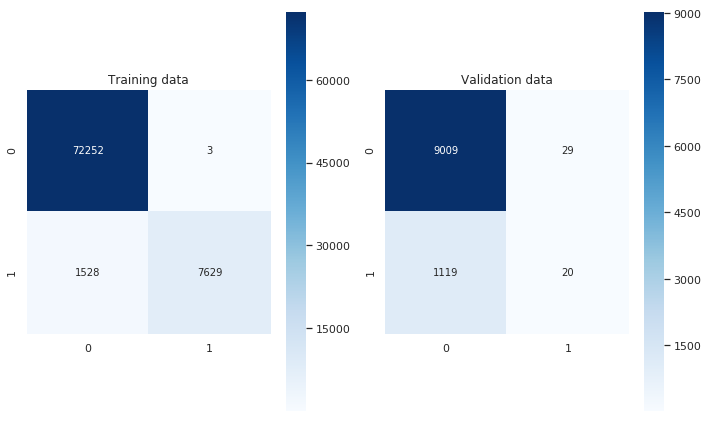

In [8]:
def test_model(X_train, y_train, X_valid, y_valid, clf):
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_train, clf.predict(X_train)), cmap=plt.cm.Blues, square=True, annot=True, fmt='d', ax=ax1);
    ax1.set_title('Training data')
    sns.heatmap(confusion_matrix(y_valid, clf.predict(X_valid)), cmap=plt.cm.Blues, square=True, annot=True, fmt='d', ax=ax2);
    ax2.set_title('Validation data');
    plt.tight_layout();
    score_table = pd.DataFrame(columns=['training data', 'validation data'])
    score_table.loc['precision score', 'training data'] = precision_score(y_train, clf.predict(X_train))
    score_table.loc['recall score', 'training data'] = recall_score(y_train, clf.predict(X_train))
    score_table.loc['Fbeta score', 'training data'] = fbeta_score(y_train, clf.predict(X_train), beta=0.2)
    score_table.loc['Mattews correlation coefficient', 'training data'] = matthews_corrcoef(y_train, clf.predict(X_train))
    score_table.loc['accuracy score', 'training data'] = accuracy_score(y_train, clf.predict(X_train))
    score_table.loc['precision score', 'validation data'] = precision_score(y_valid, clf.predict(X_valid))
    score_table.loc['recall score', 'validation data'] = recall_score(y_valid, clf.predict(X_valid))
    score_table.loc['Fbeta score', 'validation data'] = fbeta_score(y_valid, clf.predict(X_valid), beta=0.2)
    score_table.loc['Mattews correlation coefficient', 'validation data'] = matthews_corrcoef(y_valid, clf.predict(X_valid))
    score_table.loc['accuracy score', 'validation data'] = accuracy_score(y_valid, clf.predict(X_valid))
    return score_table
clf = RandomForestClassifier(n_jobs=-1, random_state=42)
clf.fit(np.concatenate((X_train, X_hold1)), np.concatenate((y_train, y_hold1)))
test_model(np.concatenate((X_train, X_hold1)), np.concatenate((y_train, y_hold1)), X_hold2, y_hold2, clf)

## Undersampling to deal with imbalanced classes

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,training data,validation data
precision score,0.995212,0.146513
recall score,0.975975,0.457419
Fbeta score,0.994458,0.150446
Mattews correlation coefficient,0.97146,0.0804156
accuracy score,0.985639,0.641053


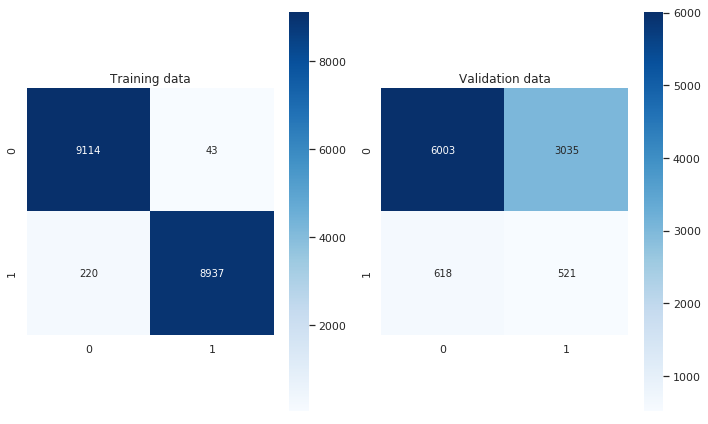

In [9]:
clf_rus = RandomForestClassifier(n_jobs=-1, random_state=42)
clf_rus.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf_rus)

## Trying oversampling

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,training data,validation data
precision score,0.999204,0.163752
recall score,0.990575,0.0904302
Fbeta score,0.99887,0.1588
Mattews correlation coefficient,0.989823,0.0421985
accuracy score,0.994893,0.846517


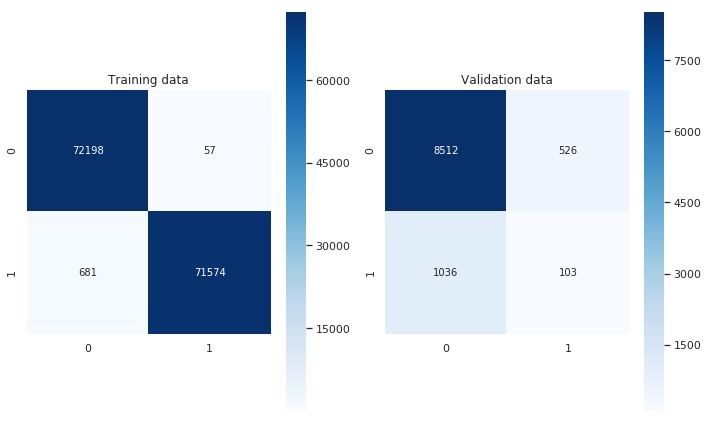

In [10]:
X_smote, y_smote = SMOTE(random_state=42).fit_resample(np.concatenate((X_train, X_hold1)), np.concatenate((y_train, y_hold1)))
clf_smote = RandomForestClassifier(n_jobs=-1, random_state=42)
clf_smote.fit(X_smote, y_smote)
test_model(X_smote, y_smote, X_hold2, y_hold2, clf_smote)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,training data,validation data
precision score,0.998951,0.149547
recall score,0.989839,0.0869183
Fbeta score,0.998597,0.145514
Mattews correlation coefficient,0.98885,0.0314815
accuracy score,0.994404,0.842488


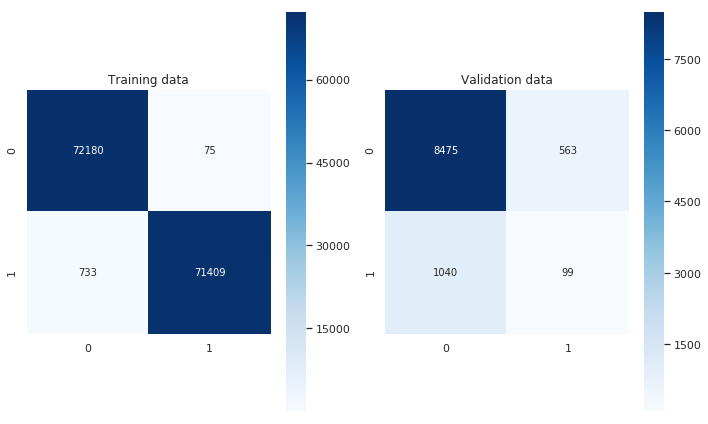

In [11]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_resample(np.concatenate((X_train, X_hold1)), np.concatenate((y_train, y_hold1)))
clf_adasyn = RandomForestClassifier(n_jobs=-1, random_state=42)
clf_adasyn.fit(X_adasyn, y_adasyn)
test_model(X_adasyn, y_adasyn, X_hold2, y_hold2, clf_adasyn)

## Optimizing RandomForest for recall

In [12]:
rus = RandomUnderSampler(return_indices=True, random_state=42)
X_rus, y_rus, id_rus = rus.fit_sample(X_train, y_train)

In [ ]:
max_depths = [2, 5, 10, 20, 40, None]
min_samples_splits = [2, 3, 5, 7, 10, 50]
n_estimators_range = [2, 5, 10, 20, 40, 60, 100]
max_features_range = [2, 5, 7, 10, 15, 20, 25, 30]
def tune_DT(X_train, y_train, X_valid, y_valid, n_estimators_range, max_depths, min_samples_splits, max_features_range, beta=0.2, random_state=42):
    score_table = pd.DataFrame(columns = ['n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'Fbeta_score', 'precision_score', 'recall_score', 'f1_score', 'matthews_corrcoef'])
    i = 0
    for n_estimators in n_estimators_range:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for max_features in max_features_range:
                    clf = RandomForestClassifier(n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           min_samples_split=min_samples_split,
                                           max_features=max_features,
                                           n_jobs=-1, 
                                           random_state=42)
                    clf.fit(X_train, y_train)
                    score_table.loc[i, 'n_estimators'] = n_estimators
                    score_table.loc[i, 'max_features'] = max_features
                    score_table.loc[i, 'max_depth'] = max_depth
                    score_table.loc[i, 'min_samples_split'] = min_samples_split
                    score_table.loc[i, 'Fbeta_score'] = fbeta_score(y_valid, clf.predict(X_valid), beta=beta)
                    score_table.loc[i, 'precision_score'] = precision_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'recall_score'] = recall_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'f1_score'] = f1_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'matthews_corrcoef'] = matthews_corrcoef(y_valid, clf.predict(X_valid))
                    i += 1

    return score_table

RF_score_table = tune_DT(X_rus, y_rus, X_hold1, y_hold1, n_estimators_range, max_depths, min_samples_splits, max_features_range, beta=0.2, random_state=42)
RF_score_table.head()

In [ ]:
RF_score_table.loc[RF_score_table.recall_score == np.max(RF_score_table.recall_score)]

,training data,validation data
precision score,0.605574,0.160821
recall score,0.609807,0.61194
Fbeta score,0.605736,0.165514
Mattews correlation coefficient,0.212629,0.133591
accuracy score,0.606312,0.599194


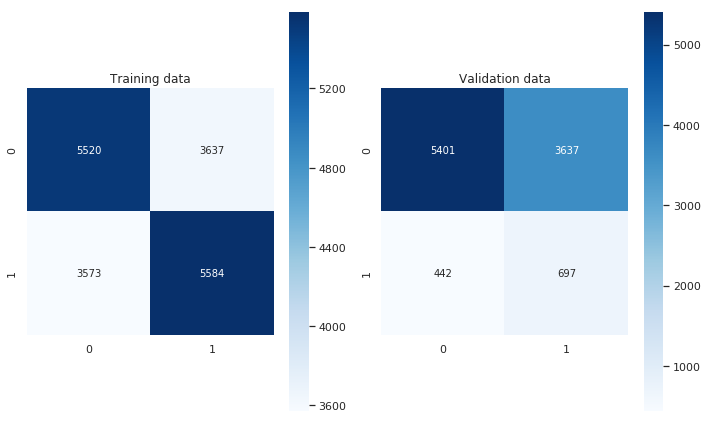

In [13]:
clf = RandomForestClassifier(
    n_estimators=10,
    max_depth=2,
    min_samples_split=2,
    max_features=30,
    n_jobs=-1, 
    random_state=42)
clf.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf)

## Optimizing for precision

In [ ]:
RF_score_table.loc[RF_score_table.precision_score == np.max(RF_score_table.precision_score)]

,training data,validation data
precision score,0.73238,0.165119
recall score,0.710385,0.5777
Fbeta score,0.731509,0.169783
Mattews correlation coefficient,0.451006,0.135373
accuracy score,0.725401,0.625823


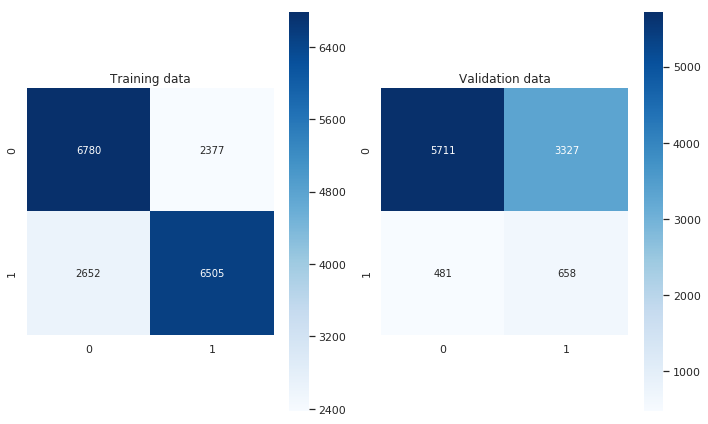

In [14]:
clf = RandomForestClassifier(
    n_estimators=40,
    max_depth=10,
    min_samples_split=7,
    max_features=10,
    n_jobs=-1, 
    random_state=42)
clf.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf)

## Optimizing for Fbeta score with beta = 0.2

In [ ]:
RF_score_table.loc[RF_score_table.Fbeta_score == np.max(RF_score_table.Fbeta_score)]

,training data,validation data
precision score,0.73238,0.165119
recall score,0.710385,0.5777
Fbeta score,0.731509,0.169783
Mattews correlation coefficient,0.451006,0.135373
accuracy score,0.725401,0.625823


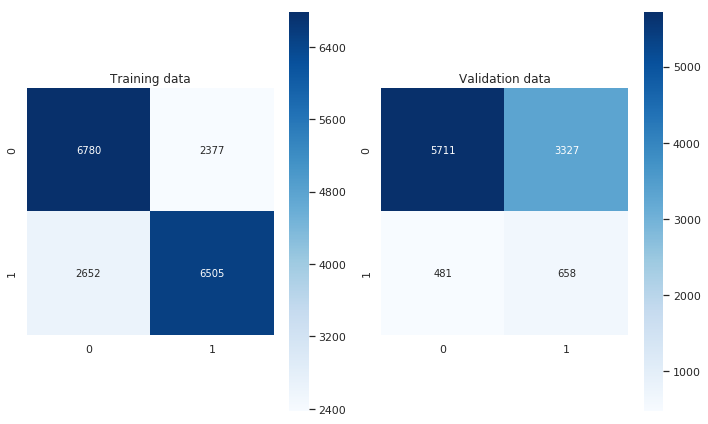

In [15]:
clf = RandomForestClassifier(
    n_estimators=40,
    max_depth=10,
    min_samples_split=7,
    max_features=10,
    n_jobs=-1, 
    random_state=42)
clf.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf)

In [16]:
values = sorted(zip(cols, clf.feature_importances_), key=lambda x: x[1] * -1)
pd.DataFrame(values, columns=['variable', 'feature_importance'])

,variable,feature_importance
0,number_inpatient,0.164329
1,discharge_disposition_id,0.074867
2,num_lab_procedures,0.037187
3,time_in_hospital,0.035044
4,num_medications,0.035007
5,diag_1,0.033017
6,number_emergency,0.030919
7,level_4_diag_1,0.028580
8,level_5_diag_1,0.028506
9,simple_diag_3,0.027748


## Trying Logistic Regression

In [17]:
scaler = MinMaxScaler()
scaler.fit(X_rus)
X_rus_scaled = scaler.transform(X_rus)
X_hold1_scaled = scaler.transform(X_hold1)
X_hold2_scaled = scaler.transform(X_hold2)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
logreg = LogisticRegression(penalty='l2', solver='newton-cg', C=10, multi_class='multinomial', random_state=42, n_jobs=-1)
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_rus_scaled, y_rus)
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True False False False False False False  True
  True  True False False False  True False False False False False  True
 False False False False False False False  True  True False  True False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True False False False  True
  True False  True  True  True False False False False False False False
 False False False False False False False False False False False]
[36 53  5 18  1 17 13 35 29 24 32  1  1  1 41 58 12  1 30 28  9  2 20  1
  4 64 33 40 21  7 14  1  1 63  1 22  8  3 62 61 60 50 10 44 59 39  6 19
 34 46  1  1  1  1  1  1 16 11 23  1  1 25  1  1  1 55 27 37 54 15 26 52
 45 56 57 31 38 47 42 43 48 49 51]


In [19]:
cols[rfe.support_]

Index(['discharge_disposition_id', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'chlorpropamide', 'acarbose',
       'miglitol', 'tolazamide', 'simple_diag_1', 'simple_diag_2',
       'simple_diag_3', 'level_2_diag_1', 'level_3_diag_1', 'level_4_diag_1',
       'level_4_diag_2', 'level_5_diag_2', 'level_3_diag_3', 'level_4_diag_3',
       'level_5_diag_3'],
      dtype='object')

,training data,validation data
precision score,0.627014,0.171272
recall score,0.480184,0.467954
Fbeta score,0.619725,0.175553
Mattews correlation coefficient,0.200105,0.124949
accuracy score,0.597271,0.687039


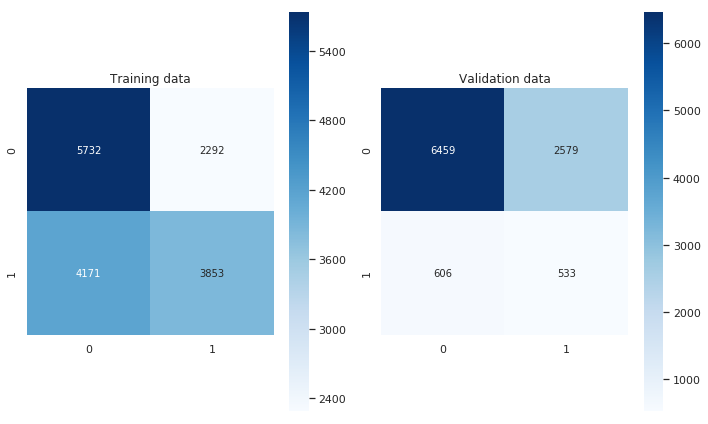

In [20]:
logreg = LogisticRegression(penalty='l2', solver='newton-cg', C=10, multi_class='multinomial', random_state=42, n_jobs=-1)
logreg.fit(X_rus_scaled[:, rfe.support_], y_rus)
test_model(X_rus_scaled[:, rfe.support_], y_rus, X_hold2_scaled[:, rfe.support_], y_hold2, logreg)

In [ ]:
C_param_range = [0.001,0.01,0.1,1,10,100]
penalty_range = ['l1', 'l2']

def tune_logreg(X_train, y_train, X_valid, y_valid, rfe, C_param_range, penalty_range, beta=0.2, random_state=42):
    score_table = pd.DataFrame(columns = ['C_parameter', 'penalty', 'Fbeta_score', 'precision_score', 'recall_score', 'f1_score', 'matthews_corrcoef'])
    ind = 0
    for C_param in C_param_range:
        for penalty in penalty_range:
            if penalty == 'l2':
                solver = 'newton-cg'
            elif penalty == 'l1':
                solver = 'liblinear'
            logreg = LogisticRegression(penalty=penalty, solver=solver, C=C_param, random_state=random_state, n_jobs=-1)
            logreg.fit(X_train[:, rfe.support_], y_train)
            y_pred = logreg.predict(X_valid[:, rfe.support_])
            # Saving accuracy score in table
            score_table.loc[ind, 'C_parameter'] = C_param
            score_table.loc[ind, 'penalty'] = penalty
            score_table.loc[ind, 'Fbeta_score'] = fbeta_score(y_valid, y_pred, beta=beta)
            score_table.loc[ind, 'precision_score'] = precision_score(y_valid, y_pred)
            score_table.loc[ind, 'recall_score'] = recall_score(y_valid, y_pred)
            score_table.loc[ind, 'f1_score'] = f1_score(y_valid, y_pred)
            score_table.loc[i, 'matthews_corrcoef'] = matthews_corrcoef(y_valid, y_pred)    
            ind += 1
    return score_table

logreg_score_table = tune_logreg(X_rus_scaled, y_rus, X_hold1_scaled, y_hold1, rfe, C_param_range, penalty_range, beta=0.2, random_state=42)
logreg_score_table.head()

In [ ]:
logreg_score_table.loc[logreg_score_table.Fbeta_score == np.max(logreg_score_table.Fbeta_score)]

In [21]:
scaler = MinMaxScaler()
X_rus_combined = np.concatenate((X_rus, X_hold1))
y_rus_combined = np.concatenate((y_rus, y_hold1))
scaler.fit(X_rus_combined)
X_rus_combined_scaled = scaler.transform(X_rus_combined)
X_hold2_combined_scaled = scaler.transform(X_hold2)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,training data,validation data
precision score,0.596178,0.274809
recall score,0.153325,0.158033
Fbeta score,0.536571,0.267215
Mattews correlation coefficient,0.162746,0.135511
accuracy score,0.66809,0.859094


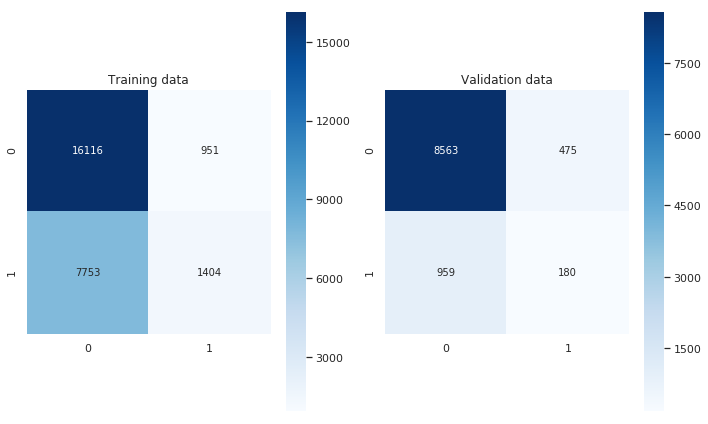

In [22]:
logreg = LogisticRegression(penalty='l1', solver='liblinear', C=10, random_state=42)
logreg.fit(X_rus_combined_scaled[:, rfe.support_], y_rus_combined)
test_model(X_rus_combined_scaled[:, rfe.support_], y_rus_combined, X_hold2_combined_scaled[:, rfe.support_], y_hold2, logreg)

## Trying AdaBoost

,training data,validation data
precision score,1,0.132224
recall score,1,0.544337
Fbeta score,1,0.13619
Mattews correlation coefficient,1,0.0595339
accuracy score,1,0.54918


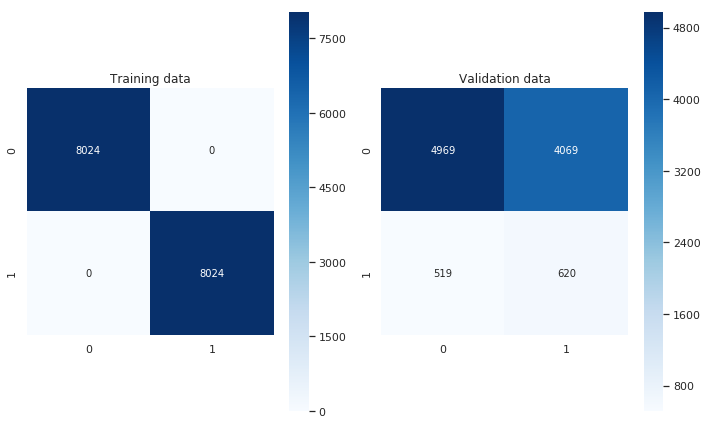

In [23]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier())
ada_clf.fit(X_rus, y_rus)
test_model(X_rus, y_rus, X_hold2, y_hold2, ada_clf)

,training data,validation data
precision score,0.738965,0.15223
recall score,0.72819,0.572432
Fbeta score,0.738545,0.156653
Mattews correlation coefficient,0.471012,0.108996
accuracy score,0.735481,0.595362


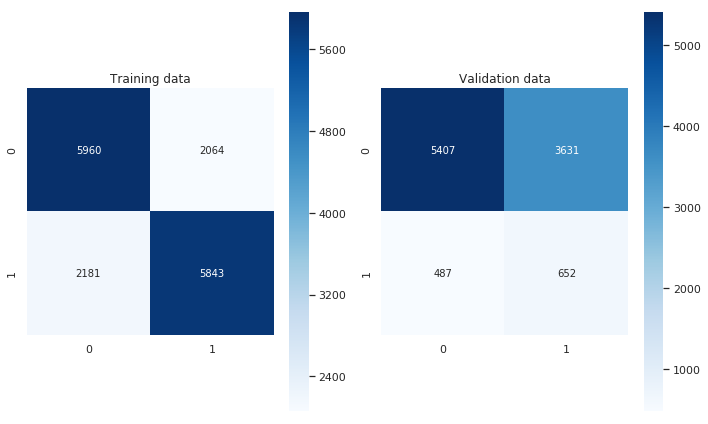

In [24]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)
ada_clf.fit(X_rus, y_rus)
test_model(X_rus, y_rus, X_hold2, y_hold2, ada_clf)

In [ ]:
max_depths = [2, 5, 10, 20, 40, None]
min_samples_splits = [2, 3, 5, 7, 10, 50]
n_estimators_range = [2, 5, 10, 20, 40, 60, 100]

ada_score_table = pd.DataFrame(columns = ['n_estimators', 'max_depth', 'min_samples_split', 'Fbeta_score', 'precision_score', 'recall_score', 'f1_score', 'matthews_corrcoef'])
i = 0
for n_estimators in n_estimators_range:
    for max_depth in max_depths:
        for min_samples_split in min_samples_splits:
            ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                               min_samples_split=min_samples_split),
                                      n_estimators=n_estimators,
                                      random_state=42)
            ada_clf.fit(X_rus, y_rus)
            ada_score_table.loc[i, 'n_estimators'] = n_estimators
            ada_score_table.loc[i, 'max_depth'] = max_depth
            ada_score_table.loc[i, 'min_samples_split'] = min_samples_split
            ada_score_table.loc[i, 'Fbeta_score'] = fbeta_score(y_hold1, ada_clf.predict(X_hold1), beta=0.2)
            ada_score_table.loc[i, 'precision_score'] = precision_score(y_hold1, ada_clf.predict(X_hold1))
            ada_score_table.loc[i, 'recall_score'] = recall_score(y_hold1, ada_clf.predict(X_hold1))
            ada_score_table.loc[i, 'f1_score'] = f1_score(y_hold1, ada_clf.predict(X_hold1))
            ada_score_table.loc[i, 'matthews_corrcoef'] = matthews_corrcoef(y_hold1, ada_clf.predict(X_hold1))
            i += 1

print(ada_score_table.loc[ada_score_table.Fbeta_score == np.max(ada_score_table.Fbeta_score)])
ada_score_table.head()

,training data,validation data
precision score,0.572367,0.2366
recall score,0.275964,0.271291
Fbeta score,0.54966,0.23777
Mattews correlation coefficient,0.210646,0.151743
accuracy score,0.675183,0.820478


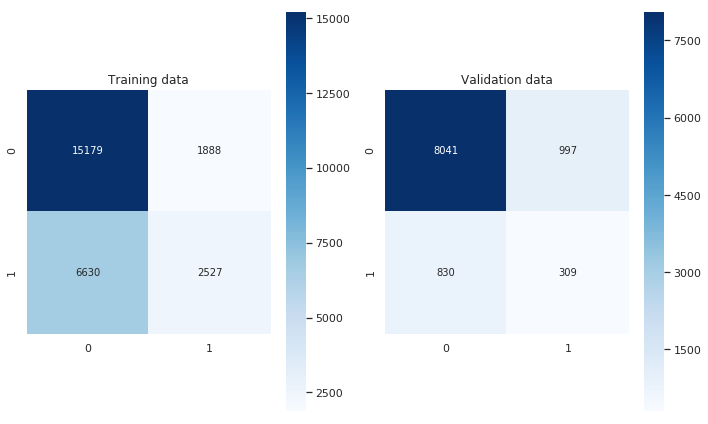

In [25]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(
    max_depth=2,
    min_samples_split=50),
    n_estimators=20,
    random_state=42)
ada_clf.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, ada_clf)

## Trying GradientBoostingClassifier

,training data,validation data
precision score,0.640648,0.284803
recall score,0.237523,0.235294
Fbeta score,0.601391,0.282517
Mattews correlation coefficient,0.235779,0.175037
accuracy score,0.687233,0.848285


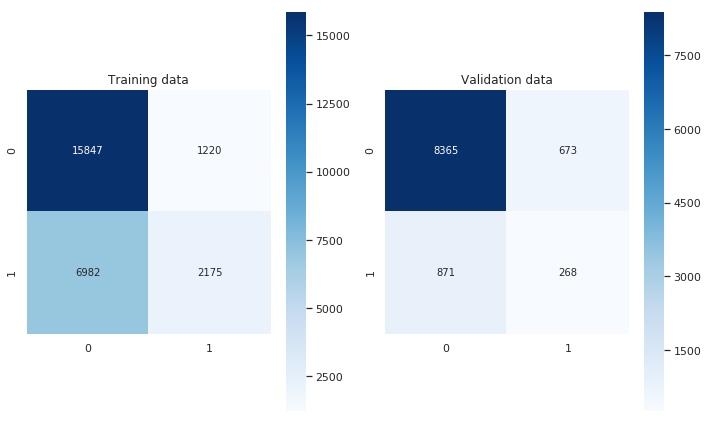

In [26]:
gbc = GradientBoostingClassifier()
gbc.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, gbc)

In [ ]:
max_depths = [2, 5, 10, 20, 40, None]
min_samples_splits = [2, 3, 5, 7, 10, 50]
n_estimators_range = [2, 5, 10, 20, 40, 60, 100]
max_features_range = [2, 5, 7, 10, 15, 20, 25, 30]

def tune_GBC(X_train, y_train, X_valid, y_valid, n_estimators_range, max_depths, min_samples_splits, max_features_range, beta=0.2, random_state=42):
    score_table = pd.DataFrame(columns = ['n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'Fbeta_score', 'precision_score', 'recall_score', 'f1_score', 'matthews_corrcoef'])
    i = 0
    for n_estimators in n_estimators_range:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for max_features in max_features_range:
                    clf = GradientBoostingClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        max_features=max_features,
                        random_state=random_state)
                    clf.fit(X_train, y_train)
                    score_table.loc[i, 'n_estimators'] = n_estimators
                    score_table.loc[i, 'max_features'] = max_features
                    score_table.loc[i, 'max_depth'] = max_depth
                    score_table.loc[i, 'min_samples_split'] = min_samples_split
                    score_table.loc[i, 'Fbeta_score'] = fbeta_score(y_valid, clf.predict(X_valid), beta=beta)
                    score_table.loc[i, 'precision_score'] = precision_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'recall_score'] = recall_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'f1_score'] = f1_score(y_valid, clf.predict(X_valid))
                    score_table.loc[i, 'matthews_corrcoef'] = matthews_corrcoef(y_valid, clf.predict(X_valid))
                    i += 1

    return score_table

GBC_score_table = tune_GBC(X_rus, y_rus, X_hold1, y_hold1, n_estimators_range, max_depths, min_samples_splits, max_features_range, beta=0.2, random_state=42)
GBC_score_table.head()

In [ ]:
GBC_score_table.loc[GBC_score_table.Fbeta_score == np.max(GBC_score_table.Fbeta_score)]

,training data,validation data
precision score,1,0.232908
recall score,1,0.272169
Fbeta score,1,0.234207
Mattews correlation coefficient,1,0.148861
accuracy score,1,0.818218


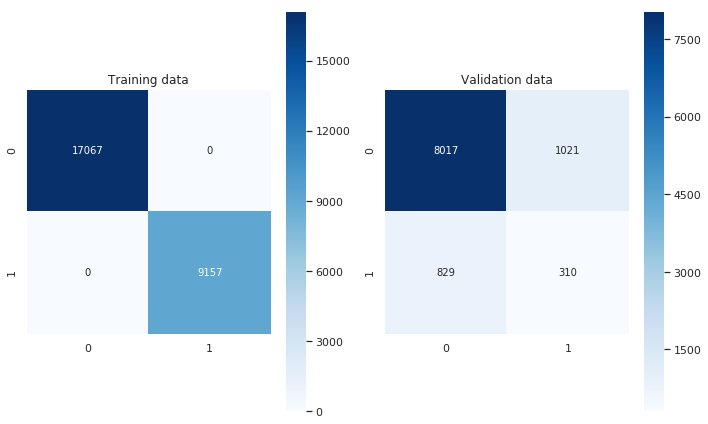

In [27]:
clf = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=7,
    max_features=15,
    random_state=42)
clf.fit(X_rus_combined, y_rus_combined)
test_model(X_rus_combined, y_rus_combined, X_hold2, y_hold2, clf)

In [ ]:
GBC_score_table.loc[GBC_score_table.matthews_corrcoef == np.max(GBC_score_table.matthews_corrcoef)]

## Trying Support Vector Machines

In [ ]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1, 10]
kernels = ['rbf', 'poly', 'linear']
def tune_SVC(X_train, y_train, X_valid, y_valid, Cs, gammas, kernels, beta=0.2, random_state=42):
    score_table = pd.DataFrame(columns = ['C', 'gamma', 'kernel', 'Fbeta_score', 'precision_score', 'recall_score', 'f1_score', 'matthews_corrcoef'])
    i = 0
    for C in Cs:
        for gamma in sorted(gammas):
            for kernel in kernels:
                if kernel == 'linear' and gamma > min(gammas):
                    continue
                clf = SVC(C=C, kernel=kernel, gamma=gamma, random_state=random_state)
                clf.fit(X_train, y_train)
                score_table.loc[i, 'C'] = C
                score_table.loc[i, 'gamma'] = gamma
                score_table.loc[i, 'kernel'] = kernel
                score_table.loc[i, 'Fbeta_score'] = fbeta_score(y_valid, clf.predict(X_valid), beta=beta)
                score_table.loc[i, 'precision_score'] = precision_score(y_valid, clf.predict(X_valid))
                score_table.loc[i, 'recall_score'] = recall_score(y_valid, clf.predict(X_valid))
                score_table.loc[i, 'f1_score'] = f1_score(y_valid, clf.predict(X_valid))
                score_table.loc[i, 'matthews_corrcoef'] = matthews_corrcoef(y_valid, clf.predict(X_valid))
                i += 1
    return score_table
SVC_score_table = tune_SVC(X_rus_scaled, y_rus, X_hold1_scaled, y_hold1, Cs, gammas, kernels, beta=0.2, random_state=42)
SVC_score_table.head()

In [ ]:
SVC_score_table.loc[SVC_score_table.Fbeta_score == np.max(SVC_score_table.Fbeta_score)]

In [ ]:
print(SVC_score_table)

## Resplitting the data with just one holdout set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['encounter_id', 'patient_nbr', 'payer_code', 'readmitted'],
                                                           axis=1), 
                                                    df[['readmitted']], 
                                                    test_size=0.1, 
                                                    random_state=42)
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X_train, y_train)

In [ ]:
best_score=0
for n_estimators in [2, 5, 10, 20, 50, 100]:
    for max_depth in [2, 5, 10, 20, 50, 100, 150, None]:
        for max_features in [2, 5, 10, 20, 50, 83]:
                clf=RandomForestClassifier(n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           max_features=max_features,
                                           n_jobs=-1, 
                                           random_state=42,
                                           oob_score=True)
                clf.fit(X_rus, y_rus)
                current_score = clf.oob_score_
                if current_score > best_score:
                    best_params = {'n_estimators':n_estimators,
                                   'max_depth':max_depth,
                                   'max_features':max_features}
                    best_score = current_score

In [ ]:
best_params

In [ ]:
best_score

It appears to be the out-of-bag accuracy score. Is this OK to use since the dataset is rebalanced using undersampling?

## Fitting a model on Principal Components

In [28]:
pca = PCA(n_components=3)
X = df[df.columns.difference(['readmitted'])]
y = df['readmitted']
pca.fit(X_train)
X_train_pcs = pca.transform(X_train)
X_hold1_pcs = pca.transform(X_hold1)
X_hold2_pcs = pca.transform(X_hold2)
X_hold3_pcs = pca.transform(X_hold3)

,training data,validation data
precision score,0.642857,1
recall score,0.00112164,0.000877963
Fbeta score,0.0279436,0.0223368
Mattews correlation coefficient,0.0235134,0.0279245
accuracy score,0.887416,0.888179


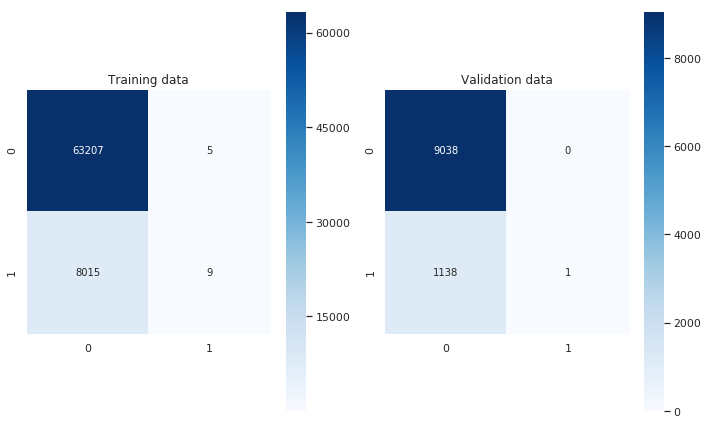

In [29]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(
    max_depth=2,
    min_samples_split=50),
    n_estimators=20,
    random_state=42)
ada_clf.fit(X_train_pcs, y_train)
test_model(X_train_pcs, y_train, X_hold2_pcs, y_hold2, ada_clf)